# **NorSand** Model Rudimentary Calibration Tool Ver_0.0.0
**[Omar Mahdy](https://www.linkedin.com/in/omarmahdy/) - Geotechnical Engineer at Dar**

**NorSand** is a widely used constitutive model designed by Jefferies (1993) to encapsulate the behavior of particulate materials. It has undergone subsequent updates, including refinements by Shuttle and Jefferies (1998), as well as modifications by Jefferies and Shuttle in 2002 and 2011.

For further explanation, visit the [Enhancing Norsand Model Understanding Through Visualizations](https://srinivas12viv.github.io/NorSand/).

<div class="toc-container">
    <h2 class="toc-title">Table of Contents</h2>
    <ul class="toc-list">
        <li>Initialization</li>
        <li>Model Parameters</li>
        <li>Trixial Test Configuration</li>
        <li>Assigning Reference Parameters</li>
        <li>Processing Functions</li>
        <li>Plotting Functions</li>
        <li>Animating Functions</li>
    </ul>
</div>


**Disclaimer**:
Don't forget to add your snippets to load the lab test data

# 1. Initialization

## 1.1 Import libraries and modules

In [76]:
# Uncomment if the needed modules  not installed
# !python -m pip install pandas matplotlib

# Data Manipulation
import pandas as pd

# Mathematical operations
import numpy as np

# Visualization and plotting
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from matplotlib.animation import FuncAnimation, PillowWriter

## 1.2 Connecting to PLAXIS server

In [77]:
from plxscripting.easy import *
localhostport_input = 10000
password = 'YeyRX$11LV<aDS3T'
s_s, g_s = new_server('localhost', localhostport_input, password=password)

# 2. TX Test Configuration

In [78]:
cell_pressure    = 100               # cell pressure [kPa]
consolidation   = 'Isotropic'       # Isotropic | K0
K0              = 0.75              # for K0 consolidation (Irrelevant if Isotropic)
behavior        = 'undrained'         # drained | undrained
direction       = 'compression'     # compression | extension
emax            = 7                 # Maximum strain eyy
steps           = 300                # Number of steps

# 3. NorSand Model Refernce Parameters

In [79]:
# Elasticity Parameters
G_ref     = 22000     # Reference value of the shear modulus at the reference pressure [kPa]
P_ref     = 100    # Reference mean pressure (generally 100 kPa is used) [kPa]
n_G       = 0.6     # Exponent of the power-law elasticity [-]
ν         = 0.2      # Poisson's ratio [-]

# Critical State Locus Parameters (Logarithmic expression of the CSL)
λ_e       = 0.030     # Slope of the critical state (e-ln(p)) [-]
Γ         = 1        # Void ratio corresponding to a mean pressure of 1 kPa [-]

# Dilatancy Limit Parameters
χ_tc      = 4   # Dilatancy limit param. [-]

# Strength Parameters
M_tc      = 1.2      # Friction ratio at critical state in triaxial conditions [-]
N         = 0.2    # Material parameter controlling the maximum stress ratio as a function of the minimum dilatancy [-]

# Plastic Hardening Parameters
H_0       = 200        # Hardening parameter at ψ = 0.0 [-]
H_ψ       = 0       # State-parameter-hardening rate [-]

# Initial State Parameters
Ψ_0       = 0.05     # Initial value of the state parameter [-]
R         = 1        # Overconsolidation ratio [-]

# Miscellaneous Parameters
S         = 1        # Softening parameter [-]

# 4. Assign Reference Parameters

In [80]:
# Assign test configuration params
g_s.Triaxial.CellPressure               = cell_pressure
g_s.Triaxial.MaximumStrain              = emax
g_s.Triaxial.Steps                      = steps
g_s.Triaxial.Behaviour                  = behavior
g_s.Triaxial.Direction                  = 'Compression'
g_s.Triaxial.Consolidation              = consolidation

if consolidation == 'K0':
    g_s.Triaxial.Consolidation = 'K0'
    g_s.Triaxial.K0 = K0

# Assign material model params
g_s.Material.User1  = G_ref 
g_s.Material.User2  = P_ref
g_s.Material.User3  = n_G
g_s.Material.User4  = ν
g_s.Material.User5  = Γ
g_s.Material.User6  = λ_e
g_s.Material.User7  = M_tc
g_s.Material.User8  = N
g_s.Material.User9  = χ_tc
g_s.Material.User10 = H_0
g_s.Material.User11 = H_ψ
g_s.Material.User12 = R
g_s.Material.User13 = S
g_s.Material.User14 = Ψ_0

# 5. Processing Functions

In [81]:
def calculate_undrained():
    g_s.calculate(g_s.Triaxial)

    TriaxDat = pd.DataFrame()
    
    # Stresses
    TriaxDat['MeanEffStress'] = g_s.Triaxial.Results.MeanEffStress.value
    TriaxDat['SigmaEffective1'] = g_s.Triaxial.Results.SigmaEffective1.value
    TriaxDat['SigmaEffective2'] = g_s.Triaxial.Results.SigmaEffective2.value
    TriaxDat['SigmaEffective3'] = g_s.Triaxial.Results.SigmaEffective3.value
    TriaxDat['DeviatoricStress'] = g_s.Triaxial.Results.DeviatoricStress.value
    TriaxDat['PExcess'] = g_s.Triaxial.Results.PExcess.value
    
    # Strains
    TriaxDat['ε_1'] = g_s.Triaxial.Results.Eps1.value
    TriaxDat['ε_3'] = g_s.Triaxial.Results.Eps3.value
    TriaxDat['ε_s'] = 2/3.0*abs((TriaxDat['ε_1'] - TriaxDat['ε_3']))
    
    return TriaxDat

def calculate_drained():
    
    g_s.calculate(g_s.Triaxial)

    TriaxDat = pd.DataFrame()
    
    # Stresses
    TriaxDat['MeanEffStress'] = g_s.Triaxial.Results.MeanEffStress.value
    TriaxDat['SigmaEffective1'] = g_s.Triaxial.Results.SigmaEffective1.value
    TriaxDat['SigmaEffective3'] = g_s.Triaxial.Results.SigmaEffective3.value
    TriaxDat['DeviatoricStress'] = g_s.Triaxial.Results.DeviatoricStress.value

    # Strains
    TriaxDat['ε_1'] = g_s.Triaxial.Results.Eps1.value
    TriaxDat['ε_3'] = g_s.Triaxial.Results.Eps3.value
    TriaxDat['ε_s'] = 2/3.0*abs((TriaxDat['ε_1'] - TriaxDat['ε_3']))
    TriaxDat['ε_v'] = g_s.Triaxial.Results.TotalVolumetricStrain.value
    
    return TriaxDat

if behavior == 'undrained':
    TriaxDat = calculate_undrained()
elif behavior == 'drained':
    TriaxDat = calculate_drained()
else:
    print('Error: Check drainage type spelling!')
    
TriaxDat

,MeanEffStress,SigmaEffective1,SigmaEffective2,SigmaEffective3,DeviatoricStress,PExcess,ε_1,ε_3,ε_s
0,-100.000000,-100.000000,-100.000000,-100.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,-97.173826,-103.497660,-94.011909,-94.011909,9.485751,-5.987574,-0.000233,0.000116,0.000233
2,-94.219194,-106.149440,-88.254071,-88.254071,17.895369,-11.745996,-0.000467,0.000231,0.000465
3,-91.181195,-107.984440,-82.779573,-82.779573,25.204867,-17.220518,-0.000700,0.000347,0.000698
4,-88.109719,-109.058190,-77.635484,-77.635484,31.422706,-22.364631,-0.000933,0.000463,0.000931
...,...,...,...,...,...,...,...,...,...
296,-19.387856,-34.855903,-11.653833,-11.653833,23.202070,-88.346167,-0.069067,0.034513,0.069053
297,-19.381039,-34.844270,-11.649423,-11.649423,23.194847,-88.350578,-0.069300,0.034630,0.069286
298,-19.374322,-34.832811,-11.645078,-11.645078,23.187733,-88.354922,-0.069533,0.034746,0.069520
299,-19.367707,-34.821524,-11.640799,-11.640799,23.180725,-88.359202,-0.069767,0.034863,0.069753


# 6. Plotting Functions

## 6.1 Undrained Test Plots

In [82]:
def Plot_Undrained_Mod(TriaxDat):
    # Create a figure and subplots
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    
    # Customize common plot settings
    line_style = '-b'
    line_width = 2.5
    label_text = 'NorSand-CSL(a)'
    font_size = 12
    font_weight = 'bold'
    
    for ax in axes.flat:
        ax.set_xlabel('', fontsize=font_size, fontweight=font_weight)
        ax.set_ylabel('', fontsize=font_size, fontweight=font_weight)
        ax.tick_params(axis='both', which='both', labelsize=font_size)
        ax.grid(True, linestyle='--', alpha=0.6)
    
    # Plot on the first subplot: Stress path in q-p' space
    pf = np.array(range(0,round(min(TriaxDat['MeanEffStress']*1.2)),-2))
    qf = M_tc*pf
    axes[0,0].plot(pf,abs(qf), '--r', label = 'CSL')
    axes[0, 0].plot(TriaxDat['MeanEffStress'], TriaxDat['DeviatoricStress'],
                    line_style, linewidth=line_width, label=label_text)
    axes[0, 0].set_xlim(1.2*min(TriaxDat['MeanEffStress']), 0)
    axes[0, 0].set_ylim(0, 1.2*max(TriaxDat['DeviatoricStress']))
    axes[0, 0].minorticks_on()
    axes[0, 0].xaxis.set_minor_locator(MultipleLocator(5))
    axes[0, 0].yaxis.set_minor_locator(MultipleLocator(5))
    axes[0, 0].invert_xaxis()
    axes[0, 0].set_xlabel("p' (kPa)", fontsize=font_size, fontweight=font_weight)
    axes[0, 0].set_ylabel('q (kPa)', fontsize=font_size, fontweight=font_weight)

    # Plot on the second subplot: Excess porewater pressure with major principal strain
    axes[0, 1].plot(TriaxDat['ε_1']*100, TriaxDat['PExcess'],
                    line_style, linewidth=line_width, label=label_text)
    axes[0, 1].set_xlim(min(TriaxDat['ε_1']*100)-0.5, 0)
    axes[0, 1].set_ylim(1.2*min(TriaxDat['PExcess']),0)
    axes[0, 1].minorticks_on()
    axes[0, 1].xaxis.set_minor_locator(MultipleLocator(0.2))
    axes[0, 1].yaxis.set_minor_locator(MultipleLocator(5))
    axes[0, 1].invert_xaxis()
    axes[0, 1].invert_yaxis()
    axes[0, 1].set_xlabel('ε$_{\mathrm{1}}$ (%)',
                          fontsize=font_size, fontweight=font_weight)
    axes[0, 1].set_ylabel('P$_{\mathrm{Excess}}$',
                          fontsize=font_size, fontweight=font_weight)
    
    # Plot on the third subplot
    axes[1, 0].plot(TriaxDat['ε_1']*100, TriaxDat['DeviatoricStress'],
                    line_style, linewidth=line_width, label=label_text)
    axes[1, 0].set_xlim(min(TriaxDat['ε_1']*100)-0.5, 0)
    axes[1, 0].set_ylim(0, 1.2*max(TriaxDat['DeviatoricStress']))
    axes[1, 0].minorticks_on()
    axes[1, 0].xaxis.set_minor_locator(MultipleLocator(0.2))
    axes[1, 0].yaxis.set_minor_locator(MultipleLocator(5))
    axes[1, 0].invert_xaxis()
    axes[1, 0].set_xlabel('ε$_{\mathrm{1}}$ (%)',
                          fontsize=font_size, fontweight=font_weight)
    axes[1, 0].set_ylabel('q (kPa)', fontsize=font_size, fontweight=font_weight)
    
    # Plot on the fourth subplot
    # plotting the CSL
    sin_phi = 3*M_tc/(6+M_tc)
    sig_3_f = np.array(range(0,round(min(TriaxDat['SigmaEffective3']*1.2)),-2))
    sig_1_f = sig_3_f*((1+sin_phi)/(1-sin_phi))
    sig_1_ff = sig_3_f*((1-sin_phi)/(1+sin_phi))
    axes[1,1].plot(sig_3_f,sig_1_f, '--r', label = 'CSL')
    axes[1,1].plot(sig_3_f,sig_1_ff, '--r')
    # plot the effect stress path
    axes[1, 1].plot(TriaxDat['SigmaEffective3'], TriaxDat['SigmaEffective1'],
                    line_style, linewidth=line_width, label=label_text)
    axes[1, 1].set_xlim(min(TriaxDat['SigmaEffective3']*1.1), 0)
    axes[1, 1].set_ylim(min(TriaxDat['SigmaEffective1']*1.1), 0)
    axes[1, 1].minorticks_on()
    axes[1, 1].xaxis.set_minor_locator(MultipleLocator(5))
    axes[1, 1].yaxis.set_minor_locator(MultipleLocator(5))
    axes[1, 1].invert_yaxis()
    axes[1, 1].invert_xaxis()
    axes[1, 1].set_xlabel('σ$_{\mathrm{3}}$ (%)',
                          fontsize=font_size, fontweight=font_weight)
    axes[1, 1].set_ylabel('σ$_{\mathrm{1}}$ (%)',
                          fontsize=font_size, fontweight=font_weight)
    
    # Add legends
    for ax in axes.flat:
        ax.legend(fontsize=font_size)

    # Adjust layout
    plt.tight_layout()

    # Customize the plot background to grey
    fig.set_facecolor('#f7f7f7')

    return fig, axes

## 6.2 Drained Test Plot

In [83]:
def Plot_Drained(TriaxDat):
    # Create a figure and subplots
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    
    # Customize common plot settings
    line_style = '-b'
    line_width = 2.5
    label_text = 'NorSand-CSL(a)'
    font_size = 12
    font_weight = 'bold'
    
    for ax in axes.flat:
        ax.set_xlabel('', fontsize=font_size, fontweight=font_weight)
        ax.set_ylabel('', fontsize=font_size, fontweight=font_weight)
        ax.tick_params(axis='both', which='both', labelsize=font_size)
        ax.grid(True, linestyle='--', alpha=0.6)
    
    # Plot on the first subplot: Stress path in q-p' space
    pf = np.array(range(0,round(min(TriaxDat['MeanEffStress']*1.2)),-2))
    qf = M_tc*pf
    axes[0,0].plot(pf,abs(qf), '--r', label = 'CSL')
    axes[0, 0].plot(TriaxDat['MeanEffStress'], TriaxDat['DeviatoricStress'],
                    line_style, linewidth=line_width, label=label_text)
    axes[0, 0].set_xlim(1.2*min(TriaxDat['MeanEffStress']), 0)
    axes[0, 0].set_ylim(0, 1.2*max(TriaxDat['DeviatoricStress']))
    axes[0, 0].minorticks_on()
    axes[0, 0].xaxis.set_minor_locator(MultipleLocator(5))
    axes[0, 0].yaxis.set_minor_locator(MultipleLocator(5))
    axes[0, 0].invert_xaxis()
    axes[0, 0].set_xlabel("p' (kPa)", fontsize=font_size, fontweight=font_weight)
    axes[0, 0].set_ylabel('q (kPa)', fontsize=font_size, fontweight=font_weight)

    # Plot on the second subplot: Strain Path
    axes[0, 1].plot(TriaxDat['ε_s']*100, TriaxDat['ε_v']*100,
                    line_style, linewidth=line_width, label=label_text)
    axes[0, 1].set_xlim(0, max(TriaxDat['ε_s']*100)+0.5)
    axes[0, 1].set_ylim(1.2*min(TriaxDat['ε_v'])*100,1.2*max(TriaxDat['ε_v'])*100)
    axes[0, 1].invert_yaxis()
    axes[0, 1].minorticks_on()
    axes[0, 1].xaxis.set_minor_locator(MultipleLocator(0.2))
    axes[0, 1].yaxis.set_minor_locator(MultipleLocator(5))
    axes[0, 1].set_xlabel('ε$_{\mathrm{s}}$ (%)',
                          fontsize=font_size, fontweight=font_weight)
    axes[0, 1].set_ylabel('ε$_{\mathrm{v}}$ (%)',
                          fontsize=font_size, fontweight=font_weight)
    
    # Plot on the third subplot
    axes[1, 0].plot(TriaxDat['ε_1']*100, TriaxDat['DeviatoricStress'],
                    line_style, linewidth=line_width, label=label_text)
    axes[1, 0].set_xlim(min(TriaxDat['ε_1']*100)-0.5, 0)
    axes[1, 0].set_ylim(0, 1.2*max(TriaxDat['DeviatoricStress']))
    axes[1, 0].minorticks_on()
    axes[1, 0].xaxis.set_minor_locator(MultipleLocator(0.2))
    axes[1, 0].yaxis.set_minor_locator(MultipleLocator(5))
    axes[1, 0].invert_xaxis()
    axes[1, 0].set_xlabel('ε$_{\mathrm{1}}$ (%)',
                          fontsize=font_size, fontweight=font_weight)
    axes[1, 0].set_ylabel('q (kPa)', fontsize=font_size, fontweight=font_weight)
    
    # Plot on the fourth subplot
    axes[1, 1].plot(TriaxDat['ε_3']*100, TriaxDat['ε_1']*100,
                    line_style, linewidth=line_width, label=label_text)
    axes[1, 1].set_xlim(0, max(TriaxDat['ε_3']*100)+0.5)
    axes[1, 1].set_ylim(min(TriaxDat['ε_1']*100)-0.5, 0)
    axes[1, 1].minorticks_on()
    axes[1, 1].xaxis.set_minor_locator(MultipleLocator(0.25))
    axes[1, 1].yaxis.set_minor_locator(MultipleLocator(0.2))
    axes[1, 1].invert_yaxis()
    axes[1, 1].set_xlabel('ε$_{\mathrm{3}}$ (%)', fontsize=font_size, fontweight=font_weight)
    axes[1, 1].set_ylabel('ε$_{\mathrm{1}}$ (%)', fontsize=font_size, fontweight=font_weight)
    
    # Add legends
    for ax in axes.flat:
        ax.legend(fontsize=font_size)

    # Adjust layout
    plt.tight_layout()

    # Customize the plot background to grey
    fig.set_facecolor('#f7f7f7')

    return fig

## 6.3 Plot Triaxial Test TriaxDat

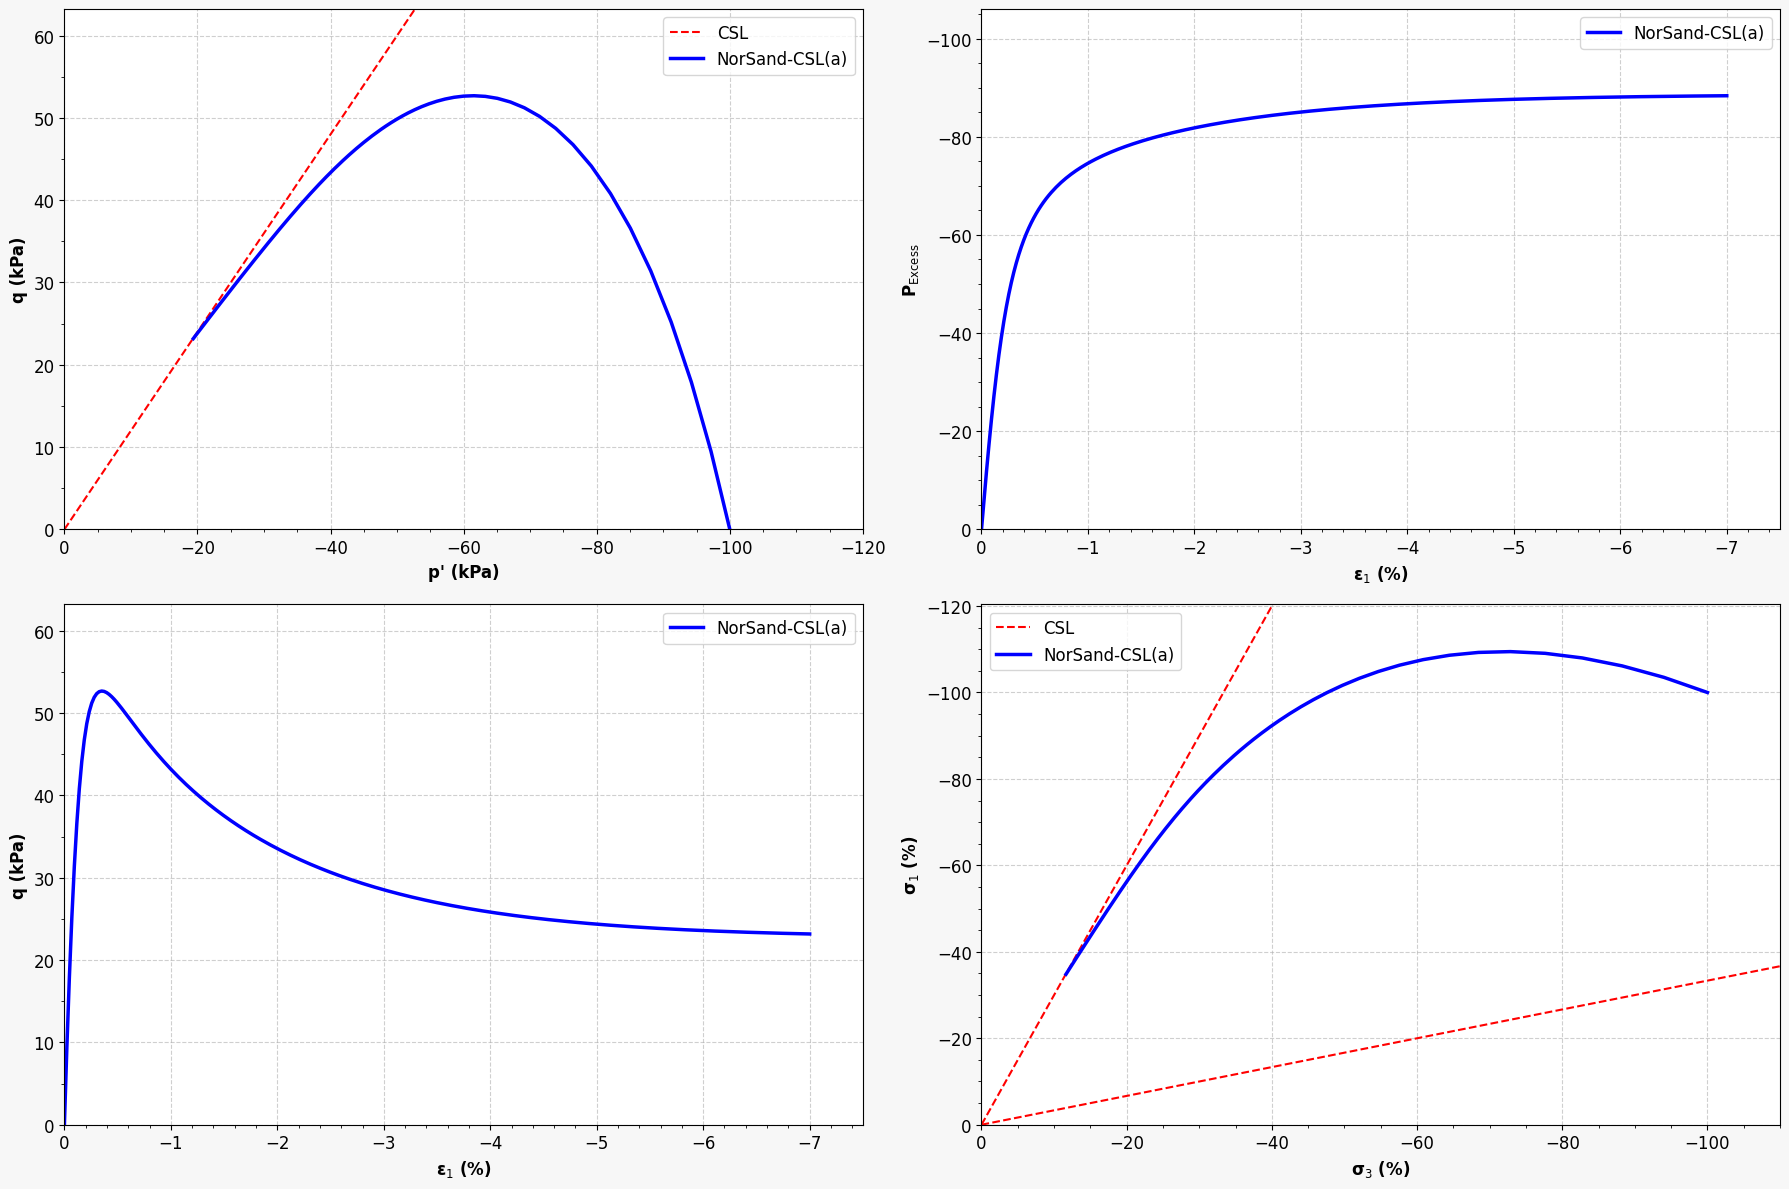

In [84]:
if behavior == 'undrained':
    figure, axes = Plot_Undrained_Mod(TriaxDat)
elif behavior == 'drained':
    figure = Plot_Drained(TriaxDat)

plt.show(figure)

try:
    figure.savefig(f"TX_{g_s.Materials[-1].Identification.value}_{behavior}_Plot.png", dpi=600)
except Exception as e:
    figure.savefig(f"TX_NorSand_Plot.png", dpi=800)